
***Make sure the kernel used is HomeBrew_Python, that's where everything is installed.

The last row of PDAC1 in immune has flipped orientation compared to the rest of them!!!! Needed to go in and manually rotate them 180*.

 ## Load libraries, functions, and data files

In [1]:
#load libraries
import numpy as np
from skimage.transform import rescale
import pystackreg
from pystackreg import StackReg
import glob
import gc
import os
import sys
import tifffile as tiff
from sys import getsizeof
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
import imagecodecs
from matplotlib.colors import ListedColormap
from skimage import measure, io

In [2]:
#Load Jenny Pfeil's Function
def identify_cells(mask, object, ROI_id): #objclass was for classifying objects, which is an extra step that I don't need! Removed
    dict_ROI = {}
   # mask = mask[..., 0]
    mask = mask.squeeze()
    if mask.shape[0] == object.shape[0] and mask.shape[1] == object.shape[1]: #and object.shape[0] == objclass.shape[0]:
        cell_ids = np.unique(np.reshape(mask, -1))
        cell_ids = cell_ids[cell_ids != 0]
        print(str(len(cell_ids)) + ' cells total')
        for cell in cell_ids:
            cell_y = mask == cell
            area = np.where(mask == cell)[0].shape[0]
            object_id = st.mode(object[cell_y])
           # if st.mode(objclass[cell_y]) == 2:
           #     
           # elif st.mode(objclass[cell_y]) == 1:
           #     object_id = 1
           # else:
           #     print('error in object classification tiff')
            dict_ROI.update({cell : [ROI_id, object_id, cell, area]})
    else:
        print(ROI_id + ' mask and object not matching')
        
    df = pd.DataFrame.from_dict(dict_ROI, columns=['ROI_id','object_id', 'cell_id', 'cell_area'], orient='index')
    return df
#df.to_csv('immune_cellid_object_assignment.csv', index=False)

In [5]:
#Folders with matched, rotated, and padded ilastik files:
epithelial_ilastik_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks"
immune_ilastik_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/immune_padded_object_masks"

In [4]:
#Dictionary:
# Read the CSV files into DataFrames

# Path to the folder containing the CSV files
ep_input_folder = "IMC_Data_Ferris/Sample_csvs"


# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(ep_input_folder) if f.endswith('.csv')]

# Initialize an empty list to hold the DataFrames
dataframes = []

# Loop through the CSV files and read them into DataFrames
for csv_file in csv_files:
    file_path = os.path.join(ep_input_folder, csv_file)
    df = pd.read_csv(file_path)  # Read the CSV into a DataFrame
    dataframes.append(df)       # Append to the list of DataFrames

# Concatenate all the DataFrames into one
ep_df = pd.concat(dataframes, ignore_index=True)

immune_input_folder = "IMC_Data_Noor/Sample_csvs"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(immune_input_folder) if f.endswith('.csv')]

# Initialize an empty list to hold the DataFrames
dataframes = []

# Loop through the CSV files and read them into DataFrames
for csv_file in csv_files:
    file_path = os.path.join(immune_input_folder, csv_file)
    df = pd.read_csv(file_path)  # Read the CSV into a DataFrame
    dataframes.append(df)       # Append to the list of DataFrames

# Concatenate all the DataFrames into one
immune_df = pd.concat(dataframes, ignore_index=True)




# Merge the DataFrames on the "Sample" column
merged_df = pd.merge(ep_df, immune_df, on='Sample', suffixes=('_ep', '_immune'))

# Create a dictionary mapping "TiffName_x" to "TiffName_y"
tiffname_mapping = dict(zip(merged_df['TiffName_ep'], merged_df['TiffName_immune']))

#make tiffname_mapping compatible with the Simple_Segmentation label
new_suffix = "full_Simple_Segmentation.tiff"
# Modify the keys and values to have the new suffix
tiffname_mapping = {
    key.replace("full.tiff", new_suffix): value.replace("full.tiff", new_suffix)
    for key, value in tiffname_mapping.items()
}

In [3]:
CAF_input_folder = "CAF_data/Sample_csvs"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(CAF_input_folder) if f.endswith('.csv')]

# Initialize an empty list to hold the DataFrames
dataframes = []

# Loop through the CSV files and read them into DataFrames
for csv_file in csv_files:
    file_path = os.path.join(CAF_input_folder, csv_file)
    df = pd.read_csv(file_path)  # Read the CSV into a DataFrame
    dataframes.append(df)       # Append to the list of DataFrames

# Concatenate all the DataFrames into one
CAF_df = pd.concat(dataframes, ignore_index=True)


## Create Transformation Matrix between Serial Section Layers

In [6]:
#custom function for creating transformation matrix 
def get_transformation_mat(ref, mov): 
    sr = StackReg(StackReg.RIGID_BODY)
    sr.register(ref, mov)
    #print('Registration matrix acquired')
    return(sr)

In [7]:
#custom function for transforming layers to show how well they overlap
def output_overlap_image(ref, mov, sr, overlay_image_filename): 
    blobs_aligned = sr.transform(mov)
    
    # Create the subplots
    f, ax = plt.subplots(1, 3, figsize=(20, 9))

    # Assuming 'ref' and 'mov' are your images
    ref = adjust_brightness(ref, gamma=6)  # Adjust the gamma for brightness
    blob_aligned_bright = adjust_brightness(blobs_aligned, gamma=6)  # Adjust the brightness for the aligned image

    # Create the composite image
    after_reg = composite_images([ref, blob_aligned_bright])

    # Plot the images in the subplots
    ax[0].imshow(ref, cmap='gray')
    ax[0].set_title('reference image')
    ax[0].axis('off')

    ax[1].imshow(mov, cmap='gray')
    ax[1].set_title('shifted image')
    ax[1].axis('off')

    ax[2].imshow(after_reg)
    ax[2].set_title('overlay (reference=red, shifted=green)')
    ax[2].axis('off')

    # Save the figure as a PNG
    plt.savefig(overlay_image_filename, bbox_inches='tight')  # Use bbox_inches to avoid extra white space
    plt.close() 

In [8]:
def composite_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs

def adjust_brightness(image, gamma=1.0):
    # Apply gamma correction to increase brightness
    return np.power(image, gamma)

## Give Unique Object IDs to Object Mask

In [9]:
#give unique ids to both object masks
def create_object_ids(ilastik_mask):  #ilastik_mask = mask
    object_mask = (ilastik_mask == 2)
    labeled_objects, num_objects = measure.label(object_mask, background=1, return_num=True)
    object_ids = {}

    # Iterate through each labeled object and assign a unique ID
    for obj_label in range(1, num_objects + 1):
        # Extract pixels belonging to the current object
        obj_pixels = (labeled_objects == obj_label)
        # Generate a unique ID for the object
        object_id = hash(obj_pixels.tobytes())
        # Store the unique ID for the object
        object_ids[object_id] = obj_label
    return(labeled_objects, num_objects, object_ids)

In [8]:
#Create a colormap with a unique color for each object
#num_colors = len(object_ids)
#colors = plt.cm.get_cmap('hsv', num_colors)
#cmap = ListedColormap(colors(np.linspace(0, 1, num_colors)))

# Overlay the labeled objects on the original mask
#plt.figure(figsize=(8, 6))
#plt.imshow(mask, cmap='gray')  # Display the original mask
#plt.imshow(labeled_objects, cmap=cmap, alpha=0.5)  # Overlay the labeled objects
#plt.colorbar(ticks=np.arange(0, num_colors, 1), label='Object ID')  # Add colorbar with object IDs
#plt.title('Objects with Unique IDs')
#plt.show()

## Calculate % Overlap between Objects from different layers

In [10]:
def calculate_object_overlap(labelled_image_1, num_objects_1, labelled_image_2, num_objects_2):
    overlap_matrix = pd.DataFrame(index=range(1, num_objects_1 + 1),
                              columns=range(1, num_objects_2 + 1),
                              dtype=float)

    for ep_label in range(1, num_objects_1 + 1):
        ep_region = (labelled_image_1 == ep_label) #ep_labelled_objects_aligned
        ep_area = ep_region.sum()  # Total area of this object

     # If area is zero, skip to avoid invalid division
        if ep_area == 0:
            continue
    
    # Loop over each object in immune_labeled_objects
        for immune_label in range(1, num_objects_2 + 1):
            immune_region = (labelled_image_2 == immune_label)
            immune_area = immune_region.sum()  # Total area of this object
            if immune_area == 0:
                continue
        
            # Find overlapping area
            overlap = np.logical_and(ep_region, immune_region)
            overlap_area = overlap.sum()
        
            # Calculate percentage overlaps, only if areas are non-zero
            if ep_area > 0:
                ep_percentage_overlap = (overlap_area / ep_area) * 100  # Relative to ep object
            else:
                ep_percentage_overlap = np.nan
        
            if immune_area > 0:
                immune_percentage_overlap = (overlap_area / immune_area) * 100  # Relative to immune object
            else:
                immune_percentage_overlap = np.nan
        
            # Store the higher percentage in the DataFrame
            overlap_matrix.at[ep_label, immune_label] = max(ep_percentage_overlap, immune_percentage_overlap)

    #Output the matrix
    #print(overlap_matrix)
    return(overlap_matrix)

 ## Run loop to overlay object masks

In [71]:
#give output folders
overlap_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks'
unique_id_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids'

#write loop using my custom functions
for key, value in tiffname_mapping.items():  # key is ep, value is immune
    try:
        # Take a pair of matching images
        ep_object_mask_path = os.path.join(epithelial_ilastik_folder, key)
        immune_object_mask_path = os.path.join(immune_ilastik_folder, value)

        # Check if files exist before proceeding
        if not os.path.exists(ep_object_mask_path) or not os.path.exists(immune_object_mask_path):
            raise FileNotFoundError(f"File(s) not found: {key}, {value}")

        # Load the images
        ep_object_mask = tiff.imread(ep_object_mask_path)
        immune_object_mask = tiff.imread(immune_object_mask_path)

        # Register them
        sr = get_transformation_mat(immune_object_mask, ep_object_mask)

        # Output the overlapped image with transformation
        overlay_image_filename = os.path.join(overlap_folder, key)  # Consider renaming if desired
        output_overlap_image(immune_object_mask, ep_object_mask, sr, overlay_image_filename)
   
    except FileNotFoundError as e:
        # If a file is not found, print the error message and skip to the next iteration
        print(f"Skipping {key}, {value}: {e}")
        continue

    except Exception as e:
        # Handle any other exceptions to ensure the loop continues
        print(f"An error occurred with {key}, {value}: {e}")
        continue

Skipping Ferris_TMA_2022_PDAC2_s0_a8_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a48_ac_full_Simple_Segmentation.tiff: File(s) not found: Ferris_TMA_2022_PDAC2_s0_a8_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a48_ac_full_Simple_Segmentation.tiff
Skipping Ferris_TMA_2022_PDAC2_s0_a29_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a21_ac_full_Simple_Segmentation.tiff: File(s) not found: Ferris_TMA_2022_PDAC2_s0_a29_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a21_ac_full_Simple_Segmentation.tiff
Skipping Ferris_TMA_2022_PDAC2_s0_a36_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a66_ac_full_Simple_Segmentation.tiff: File(s) not found: Ferris_TMA_2022_PDAC2_s0_a36_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a66_ac_full_Simple_Segmentation.tiff
Skipping Ferris_TMA_2022_PDAC2_s0_a45_ac_full_Simple_Segmentation.tiff, 2023_PDAC2_TMA_Immune_Noor_s0_a30_ac_full_Simple_Segmentation.t

KeyboardInterrupt: 

In [72]:
sr

In [73]:
output_overlap_image(immune_object_mask, ep_object_mask, sr, overlay_image_filename)

In [14]:
create_object_ids(ep_object_mask)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 48,
 {1016438847648503964: 1,
  6503164722361981460: 2,
  -1236964075423231628: 3,
  175785257111579280: 4,
  -7492889815920203382: 5,
  443432465271374129: 6,
  5208382136808486229: 7,
  67684026694054103: 8,
  -2867443604968176448: 9,
  -1241382987308912123: 10,
  -994780389114289250: 11,
  -9041768767200316875: 12,
  4487406170077863620: 13,
  4948684192706917410: 14,
  -6088435804049235858: 15,
  3655853037950378423: 16,
  -3060434366712823683: 17,
  -5915007975002688022: 18,
  -4280484302262291142: 19,
  -3878621556766563059: 20,
  9182122401383915898: 21,
  4612819143111547785: 22,
  -5340444227960410099: 23,
  -2574868226576480015: 24,
  -8781373671055714028: 25,
  -7175767464153472188: 26,
  -6139633548775582633: 27,
  866136743197896502: 28,
  -771719562

In [ ]:
#give output folders
overlap_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks'
unique_id_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids'

#write loop using my custom functions
for key, value in tiffname_mapping.items():  # key is ep, value is immune
    try:
        # Take a pair of matching images
        ep_object_mask_path = os.path.join(epithelial_ilastik_folder, key)
        immune_object_mask_path = os.path.join(immune_ilastik_folder, value)

        # Check if files exist before proceeding
        if not os.path.exists(ep_object_mask_path) or not os.path.exists(immune_object_mask_path):
            raise FileNotFoundError(f"File(s) not found: {key}, {value}")

        # Load the images
        ep_object_mask = tiff.imread(ep_object_mask_path)
        immune_object_mask = tiff.imread(immune_object_mask_path)

        # Register them
        sr = get_transformation_mat(immune_object_mask, ep_object_mask)
        
        print(sr)

        # Output the overlapped image with transformation
        overlay_image_filename = os.path.join(overlap_folder, key)  # Consider renaming if desired
        output_overlap_image(immune_object_mask, ep_object_mask, sr, overlay_image_filename)

        # Create object IDs and save the labeled object masks
        ep_labeled_objects, ep_num_objects, ep_object_ids = create_object_ids(ep_object_mask)
        immune_labeled_objects, immune_num_objects, immune_object_ids = create_object_ids(immune_object_mask)

        # Save object ID images to avoid instability in subsequent runs
        ep_output_path = os.path.join(unique_id_folder, 'epithelial', key)
        immune_output_path = os.path.join(unique_id_folder, 'new_immune', value)

        #tiff.imwrite(ep_output_path, ep_labeled_objects)
       # tiff.imwrite(immune_output_path, immune_labeled_objects)

        # Transform the epithelial object
        transformed_ep_labeled_objects = sr.transform(ep_labeled_objects)

        # Calculate object overlap and write to CSV
        overlap_matrix = calculate_object_overlap(
            transformed_ep_labeled_objects, ep_num_objects, 
            immune_labeled_objects, immune_num_objects
        )

        overlap_mat_filename = os.path.join(overlap_folder, f"{key}_overlap_matrix.csv")
        #overlap_matrix.to_csv(overlap_mat_filename, index=True, header=True)

        #print(f"Overlap matrix has been written to {overlap_mat_filename}")

    except FileNotFoundError as e:
        # If a file is not found, print the error message and skip to the next iteration
        print(f"Skipping {key}, {value}: {e}")
        continue

    except Exception as e:
        # Handle any other exceptions to ensure the loop continues
        print(f"An error occurred with {key}, {value}: {e}")
        continue

In [20]:
tiffname_mapping

{'Ferris_TMA_2022_PDAC2_s0_a5_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a75_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a6_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a82_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a7_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a62_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a8_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a18_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a9_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a90_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a10_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a8_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a11_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a65_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a12_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a73_ac_full_Simple Segmentation.tiff',
 'Ferris_TMA_2022_PDAC2_s0_a13_ac_full_Simple Segmentation.tiff': 'PDAC2_s0_a103_ac_fu

In [23]:
ep_object_mask_path = os.path.join(epithelial_ilastik_folder, key)

In [24]:
ep_object_mask = tiff.imread(ep_object_mask_path)

In [13]:
ep_num_objects

2

In [17]:
ep_object_mask #ok... so I have been grabbing the original epithelial mask, not the unique object id mask

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [15]:
ep_object_ids = np.unique(ep_object_mask)


In [16]:
ep_object_ids

array([1, 2], dtype=uint8)

In [ ]:
ep_object_ids = ep_object_ids[ep_object_ids != 0]  # Remove background label (0) if present
ep_num_objects = len(ep_object_ids)

In [19]:
np.unique(ep_labeled_objects)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=uint8)

In [20]:
# For overlaying CAF with epithelial objects, I need to load in the previous epithelial unique object IDs
#otherwise I won't be able to compare across layers


#first, make sure tiffname mapping is working
# Path to the tiffname_mapping CSV
mapping_csv_path = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/ROI_matching_csvs/CAF_ep_tiffname_mapping.csv'
# Read the CSV into a dictionary
tiffname_mapping = pd.read_csv(mapping_csv_path, index_col=0).squeeze("columns").to_dict()
#make tiffname_mapping compatible with the Simple_Segmentation label
new_suffix = "full_Simple_Segmentation.tiff"
new_suffix_CAF = "full_Simple Segmentation.tiff"
# Modify the keys and values to have the new suffix
tiffname_mapping = {
    key.replace("full.tiff", new_suffix): value.replace("full.tiff", new_suffix_CAF)
    for key, value in tiffname_mapping.items()
}


#Folders with matched, rotated, and padded ilastik files:
epithelial_ilastik_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF"
CAF_ilastik_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded"
#CAF_tiff_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded'
#epithelial_tiff_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF'

unique_id_folder_ep = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/epithelial_padded_for_CAF'

#give output folder
overlap_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep'
unique_id_folder = '/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids'


for key, value in tiffname_mapping.items():  # key is ep, value is caf
    try:
        # Take a pair of matching images
        ep_object_mask_path = os.path.join(epithelial_ilastik_folder, key)
        caf_object_mask_path = os.path.join(CAF_ilastik_folder, value)

        print(ep_object_mask_path)
        print(caf_object_mask_path)
        # Check if files exist before proceeding
        if not os.path.exists(ep_object_mask_path) or not os.path.exists(caf_object_mask_path):
            raise FileNotFoundError(f"File(s) not found: {key}, {value}")

        # Load the images
        ep_object_mask = tiff.imread(ep_object_mask_path)
        print(ep_object_mask.shape)
        caf_object_mask = tiff.imread(caf_object_mask_path)
        print(caf_object_mask.shape)

        # Register them
        sr = get_transformation_mat(caf_object_mask, ep_object_mask)

        # Output the overlapped image with transformation
        overlay_image_filename = os.path.join(overlap_folder, key)  # Consider renaming if desired
        output_overlap_image(caf_object_mask, ep_object_mask, sr, overlay_image_filename)

        # Create object IDs and save the labeled object masks
        #ep_labeled_objects, ep_num_objects, ep_object_ids = create_object_ids(ep_object_mask) #change this line to read in 

        labeled_ep_object_mask_path = os.path.join(unique_id_folder_ep, key) #HERE IS THE PROBLEM: I actually need to pad the unique_id_folder, if I'm going to be using that!
        ep_labeled_objects = tiff.imread(labeled_ep_object_mask_path)
        caf_labeled_objects, caf_num_objects, caf_object_ids = create_object_ids(caf_object_mask)

        # Extract the number of objects (excluding background, assuming background is labeled as 0)
        ep_object_ids = np.unique(ep_labeled_objects)
        ep_object_ids = ep_object_ids[ep_object_ids != 0]  # Remove background label (0) if present
        ep_num_objects = len(ep_object_ids)
        
        # Save object ID images to avoid instability in subsequent runs
        #ep_output_path = os.path.join(unique_id_folder, 'epithelial', key)
        caf_output_path = os.path.join(unique_id_folder, 'CAF', value)

        #tiff.imwrite(ep_output_path, ep_labeled_objects)
        tiff.imwrite(caf_output_path, caf_labeled_objects)

        # Transform the epithelial object
        transformed_ep_labeled_objects = sr.transform(ep_labeled_objects)

        # Calculate object overlap and write to CSV
        overlap_matrix = calculate_object_overlap(
            transformed_ep_labeled_objects, ep_num_objects, 
            caf_labeled_objects, caf_num_objects
        )

        overlap_mat_filename = os.path.join(overlap_folder, f"{key}_overlap_matrix.csv")
        overlap_matrix.to_csv(overlap_mat_filename, index=True, header=True)

        print(f"Overlap matrix has been written to {overlap_mat_filename}")

    except FileNotFoundError as e:
        # If a file is not found, print the error message and skip to the next iteration
        print(f"Skipping {key}, {value}: {e}")
        continue

    except Exception as e:
        # Handle any other exceptions to ensure the loop continues
        print(f"An error occurred with {key}, {value}: {e}")
        continue
        
        #AUG 28th: this is where I am still getting errors! This is the next challenge. 
        #Now the matching name has been fixed, its all shape errors. 
        #It seems like the correct sizes are not getting written into the folder
        

/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a5_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a75_ac_full_Simple Segmentation.tiff
(1142, 1214)
(1142, 1214)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a5_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a6_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a82_ac_full_Simple Segmentation.tiff
(1215, 1275)
(1215, 1275)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_e

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a20_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a21_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a99_ac_full_Simple Segmentation.tiff
(1205, 1268)
(1205, 1268)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a21_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a22_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a37_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a38_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a7_ac_full_Simple Segmentation.tiff
(1357, 1307)
(1357, 1307)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a38_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a39_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_fl

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a53_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a54_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a89_ac_full_Simple Segmentation.tiff
(1148, 1218)
(1148, 1218)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a54_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a55_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a73_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a74_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a98_ac_full_Simple Segmentation.tiff
(1151, 1180)
(1151, 1180)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a74_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a75_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a89_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a90_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a60_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a90_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a91_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a105_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a106_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC2_s0_a17_ac_full_Simple Segmentation.tiff
(1171, 1250)
(1171, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC2_s0_a106_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC2_s0_a107_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/C

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a8_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a9_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC7_s0_a72_ac_full_Simple Segmentation.tiff
(1210, 1207)
(1210, 1207)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a9_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a10_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/P

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a29_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a30_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC7_s0_a119_ac_full_Simple Segmentation.tiff
(1276, 1343)
(1276, 1343)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a30_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a31_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padd

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a54_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a55_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC7_s0_a45_ac_full_Simple Segmentation.tiff
(1272, 1261)
(1272, 1261)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a55_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a56_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a80_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a81_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC7_s0_a132_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a81_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a82_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padd

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a97_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a98_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC7_s0_a6_ac_full_Simple Segmentation.tiff
(1175, 1250)
(1175, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a98_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a99_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a118_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a120_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC7_s0_a57_ac_full_Simple Segmentation.tiff
(1205, 1145)
(1205, 1145)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a120_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC7_rev_s0_a121_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_p

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC7_rev_s0_a144_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a5_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a119_ac_full_Simple Segmentation.tiff
(1250, 1157)
(1250, 1157)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a5_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a6_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a1

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a26_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a29_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a77_ac_full_Simple Segmentation.tiff
(422, 597)
(422, 597)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a29_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a30_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a62_ac_fu

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a50_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a54_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a101_ac_full_Simple Segmentation.tiff
(1212, 1217)
(1212, 1217)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a54_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a55_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a30_

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a77_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a78_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a4_ac_full_Simple Segmentation.tiff
(1260, 1075)
(1260, 1075)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a78_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a79_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a110_a

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a99_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a101_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a51_ac_full_Simple Segmentation.tiff
(1206, 1250)
(1206, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a101_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a102_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a9

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a127_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC8_s0_a128_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC8_s0_a96_ac_full_Simple Segmentation.tiff
(1200, 1306)
(1200, 1306)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC8_s0_a128_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a5_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/P

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a18_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a19_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a65_ac_full_Simple Segmentation.tiff
(1287, 1250)
(1287, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a19_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a20_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_ob

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a34_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a35_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a19_ac_full_Simple Segmentation.tiff
(1262, 1347)
(1262, 1347)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a35_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a36_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_ob

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a49_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a50_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a9_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a50_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a51_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_obj

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a68_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a69_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a45_ac_full_Simple Segmentation.tiff
(1250, 1298)
(1250, 1298)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a69_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a71_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_ob

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a84_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a85_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a18_ac_full_Simple Segmentation.tiff
(1202, 1223)
(1202, 1223)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a85_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a86_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_ob

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a100_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a101_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a12_ac_full_Simple Segmentation.tiff
(1269, 1274)
(1269, 1274)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a101_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a102_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilasti

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a117_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC5_rev_s0_a118_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC5_s0_a83_ac_full_Simple Segmentation.tiff
(1281, 1281)
(1281, 1281)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC5_rev_s0_a118_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a5_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_obje

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a21_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a22_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC6_s0_a92_ac_full_Simple Segmentation.tiff
(1218, 1204)
(1218, 1204)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a22_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a23_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a38_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a39_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC6_s0_a30_ac_full_Simple Segmentation.tiff
(1091, 1006)
(1091, 1006)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a39_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a41_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a59_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a64_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC6_s0_a59_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a64_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a65_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a83_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a84_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC6_s0_a7_ac_full_Simple Segmentation.tiff
(1218, 1235)
(1218, 1235)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a84_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a85_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_fl

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a98_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a99_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC6_s0_a5_ac_full_Simple Segmentation.tiff
(1254, 1250)
(1254, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a99_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a100_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a114_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a115_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC6_s0_a97_ac_full_Simple Segmentation.tiff
(974, 755)
(974, 755)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC6_s0_a115_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC6_s0_a116_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a16_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a17_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC3_s0_a98_ac_full_Simple Segmentation.tiff
(1255, 1279)
(1255, 1279)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a17_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a18_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a33_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a34_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC3_s0_a26_ac_full_Simple Segmentation.tiff
(1161, 1230)
(1161, 1230)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a34_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a35_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a49_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a50_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC3_s0_a29_ac_full_Simple Segmentation.tiff
(1176, 1033)
(1176, 1033)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a50_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a51_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a65_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a66_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC3_s0_a94_ac_full_Simple Segmentation.tiff
(1211, 1269)
(1211, 1269)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a66_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a67_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a85_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a87_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC3_s0_a48_ac_full_Simple Segmentation.tiff
(1182, 1250)
(1182, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a87_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a88_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_f

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a102_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a103_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC3_s0_a19_ac_full_Simple Segmentation.tiff
(1205, 1182)
(1205, 1182)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/Ferris_TMA_2022_PDAC3_s0_a103_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/Ferris_TMA_2022_PDAC3_s0_a104_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/C

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a5_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a6_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a53_ac_full_Simple Segmentation.tiff
(1190, 1250)
(1190, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a6_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a7_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PD

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a21_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a23_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a9_ac_full_Simple Segmentation.tiff
(1167, 1250)
(1167, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a23_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a24_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a38_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a39_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a5_ac_full_Simple Segmentation.tiff
(1196, 1250)
(1196, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a39_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a40_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a55_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a56_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a77_ac_full_Simple Segmentation.tiff
(1176, 1267)
(1176, 1267)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a56_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a57_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a76_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a77_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a69_ac_full_Simple Segmentation.tiff
(1186, 1174)
(1186, 1174)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a77_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a78_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a92_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a93_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a43_ac_full_Simple Segmentation.tiff
(1199, 1250)
(1199, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a93_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a94_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a108_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a109_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC4_s0_a20_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC4_rev_s0_a109_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC4_rev_s0_a110_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_p

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a8_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a9_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a48_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a9_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a10_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/P

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a24_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a25_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a19_ac_full_Simple Segmentation.tiff
(1229, 1250)
(1229, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a25_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a26_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a41_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a42_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a1_ac_full_Simple Segmentation.tiff
(1250, 1291)
(1250, 1291)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a42_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a43_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a62_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a63_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a18_ac_full_Simple Segmentation.tiff
(1250, 1297)
(1250, 1297)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a63_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a64_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a78_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a79_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a42_ac_full_Simple Segmentation.tiff
(1250, 1250)
(1250, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a79_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a80_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a95_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a96_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a27_ac_full_Simple Segmentation.tiff
(1306, 1265)
(1306, 1265)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a96_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a97_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padde

Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a111_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a112_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_padded/PDAC1_s0_a41_ac_full_Simple Segmentation.tiff
(1178, 1250)
(1178, 1250)
Overlap matrix has been written to /Users/ferris/Desktop/Serial Section Overlay/000_Data/aligned_object_masks/CAF_to_ep/TMA_2022_PDAC1_rev_s0_a112_ac_full_Simple_Segmentation.tiff_overlap_matrix.csv
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/epithelial_padded_object_masks_for_CAF/TMA_2022_PDAC1_rev_s0_a113_ac_full_Simple_Segmentation.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/ilastik_object_masks/CAF_flipped_p

 ## Run loop to connect each object mask to original cell IDs

In [10]:
#make the necessary dictionaries
#ep_df = pd.read_csv('/Users/ferris/Desktop/Serial Section Overlay/000_Data/ROI_matching_csvs/Ep_PDAC1_Sample.csv')
#immune_df = pd.read_csv('/Users/ferris/Desktop/Serial Section Overlay/000_Data/ROI_matching_csvs/Immune_PDAC1_Sample.csv')

#pull dfs from earlier chunk that loads in all sample csvs and merges them

# Create a dictionary mapping "TiffName_x" to "TiffName_y"
ep_mapping = dict(zip(ep_df['TiffName'], ep_df['Sample']))
immune_mapping = dict(zip(immune_df['TiffName'], immune_df['Sample']))

### For Immune

In [58]:
#define an overlap image
def output_untransformed_overlap(ref1, ref2, overlay_image_filename): 
    # Create the subplots
    f, ax = plt.subplots(1, 3, figsize=(20, 9))

    # Assuming 'ref' and 'mov' are your images
    #ref1 = adjust_brightness(ref1, gamma=6)  # Adjust the gamma for brightness
    #ref2 = adjust_brightness(ref2, gamma=6)  # Adjust the brightness for the aligned image

    # Create the composite image
    after_reg = composite_images([ref1, ref2])

    # Plot the images in the subplots
    ax[0].imshow(ref1, cmap='gray')
    ax[0].set_title('cell segmentation mask')
    ax[0].axis('off')

    ax[1].imshow(ref2, cmap='gray')
    ax[1].set_title('ilastik panCK object mask')
    ax[1].axis('off')

    ax[2].imshow(after_reg)
    ax[2].set_title('overlay (segmented_cells=red, panCK_objects=green)')
    ax[2].axis('off')

    # Save the figure as a PNG
    plt.savefig(overlay_image_filename, bbox_inches='tight')  # Use bbox_inches to avoid extra white space
    plt.close() 

In [17]:
masks_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded"
objects_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune" #make sure to use the unique ID ones
output_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/object_cellids/new_immune" 

for key, value in immune_mapping.items():
    ROI_id = value
    mask_name = key.replace("full.tiff", "IA_mask.tiff")
    object_name = key.replace("full.tiff", "full_Simple_Segmentation.tiff")
    # Try to read the mask
    try:
        mask_path = os.path.join(masks_folder, mask_name)
        mask = tiff.imread(mask_path)
        mask = mask.squeeze()
        print(mask.shape)
        print(mask_path)
    except (FileNotFoundError, OSError):
        print(f"Error: Could not find the mask file '{mask_name}'. Skipping this item.")
        continue
    
    # Try to read the object
    try:
        object_path = os.path.join(objects_folder, object_name)
        object = tiff.imread(object_path)
        print(object_path)
    except (FileNotFoundError, OSError):
        print(f"Error: Could not find the object file '{object_name}'. Skipping this item.")
        continue
    #also output a composite image of the segmentation plus the object mask on top, so that I can check quality/orientation:
    output_untransformed_overlap(mask, object, os.path.join(output_folder, f'{ROI_id}_cellid_object_overlap.tiff'))
    df = identify_cells(mask, object, ROI_id)
    df.to_csv(os.path.join(output_folder, f'{ROI_id}_cellid_object_assignment.csv'), index=False)

(184, 496)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC8_TMA_Immune_Noor_s0_a1_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune/2023_PDAC8_TMA_Immune_Noor_s0_a1_ac_full_Simple_Segmentation.tiff
229 cells total
(1229, 1273)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC8_TMA_Immune_Noor_s0_a3_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune/2023_PDAC8_TMA_Immune_Noor_s0_a3_ac_full_Simple_Segmentation.tiff
10228 cells total
(1174, 1208)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC8_TMA_Immune_Noor_s0_a5_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune/2023_PDAC8_TMA_Immune_Noor_s0_a5_ac_full_Simple_Segmentation.tiff
12137 cells total
(1200, 1213)
/Users/ferris/De

/var/folders/lf/xlxpmk2s40l05pbstyzfn3c80000gp/T/ipykernel_72037/585505725.py:6: RuntimeWarning: invalid value encountered in divide
  imgs = [img / img.max() for img in imgs]
/opt/homebrew/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


(1205, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a100_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune/2023_PDAC4_TMA_Immune_Noor_s0_a100_ac_full_Simple_Segmentation.tiff
5977 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a101_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune/2023_PDAC4_TMA_Immune_Noor_s0_a101_ac_full_Simple_Segmentation.tiff
10500 cells total
(1185, 1185)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a102_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/new_immune/2023_PDAC4_TMA_Immune_Noor_s0_a102_ac_full_Simple_Segmentation.tiff
3844 cells total
(1174, 1186)
/U

7220 cells total
(1189, 1059)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a25_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a25_ac_full_Simple_Segmentation.tiff
3833 cells total
(1177, 1117)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a26_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a26_ac_full_Simple_Segmentation.tiff
6293 cells total
(1237, 1267)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a27_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a27_ac_full_Simple_Segmentation.tiff
10961 cells total
(1204, 1218)
/Us

5700 cells total
(1173, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a53_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a53_ac_full_Simple_Segmentation.tiff
7433 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a54_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a54_ac_full_Simple_Segmentation.tiff
7213 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a55_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a55_ac_full_Simple_Segmentation.tiff
6680 cells total
(1198, 1198)
/Use

11067 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a79_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a79_ac_full_Simple_Segmentation.tiff
10106 cells total
(1112, 1220)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a80_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a80_ac_full_Simple_Segmentation.tiff
3589 cells total
(1198, 1198)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a81_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a81_ac_full_Simple_Segmentation.tiff
4575 cells total
(1151, 1250)
/U

4343 cells total
(1162, 1210)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a105_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a105_ac_full_Simple_Segmentation.tiff
6286 cells total
(1174, 1174)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a106_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a106_ac_full_Simple_Segmentation.tiff
9139 cells total
(1155, 1224)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC4_TMA_Immune_Noor_s0_a107_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC4_TMA_Immune_Noor_s0_a107_ac_full_Simple_Segmentation.tiff
4101 cells total
(1211, 1211

3701 cells total
(1271, 1318)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a22_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a22_ac_full_Simple_Segmentation.tiff
5893 cells total
(1250, 1304)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a23_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a23_ac_full_Simple_Segmentation.tiff
7840 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a24_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a24_ac_full_Simple_Segmentation.tiff
8683 cells total
(1140, 1347)
/Use

5294 cells total
(1250, 1172)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a48_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a48_ac_full_Simple_Segmentation.tiff
9351 cells total
(1215, 1215)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a49_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a49_ac_full_Simple_Segmentation.tiff
5899 cells total
(1243, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a50_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a50_ac_full_Simple_Segmentation.tiff
3748 cells total
(1250, 1250)
/Use

7338 cells total
(905, 1159)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a74_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a74_ac_full_Simple_Segmentation.tiff
4385 cells total
(748, 505)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a76_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a76_ac_full_Simple_Segmentation.tiff
844 cells total
(1280, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a77_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a77_ac_full_Simple_Segmentation.tiff
8302 cells total
(1213, 1219)
/Users/f

7345 cells total
(1322, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a101_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a101_ac_full_Simple_Segmentation.tiff
3793 cells total
(1219, 1159)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a102_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a102_ac_full_Simple_Segmentation.tiff
3741 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC5_TMA_Immune_Noor_s0_a103_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC5_TMA_Immune_Noor_s0_a103_ac_full_Simple_Segmentation.tiff
6322 cells total
(1250, 1250

7875 cells total
(992, 1104)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a23_ac_IA_mask.tiff
Error: Could not find the object file '2023_PDAC7_TMA_Immune_Noor_s0_a23_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(1250, 1257)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a24_ac_IA_mask.tiff
Error: Could not find the object file '2023_PDAC7_TMA_Immune_Noor_s0_a24_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(1261, 1279)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a27_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a27_ac_full_Simple_Segmentation.tiff
7060 cells total
(1294, 1284)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_mas

4440 cells total
(1181, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a57_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a57_ac_full_Simple_Segmentation.tiff
9214 cells total
(1279, 1279)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a62_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a62_ac_full_Simple_Segmentation.tiff
10005 cells total
(1208, 1208)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a63_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a63_ac_full_Simple_Segmentation.tiff
5558 cells total
(1205, 1145)
/Us

/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a98_ac_full_Simple_Segmentation.tiff
4253 cells total
(1223, 1235)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a99_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a99_ac_full_Simple_Segmentation.tiff
3659 cells total
(1250, 1314)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a100_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a100_ac_full_Simple_Segmentation.tiff
6603 cells total
(1289, 1323)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a102_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Se

8507 cells total
(1283, 1291)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a132_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a132_ac_full_Simple_Segmentation.tiff
4536 cells total
(1284, 1294)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a133_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a133_ac_full_Simple_Segmentation.tiff
4552 cells total
(1175, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC7_TMA_Immune_Noor_s0_a134_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC7_TMA_Immune_Noor_s0_a134_ac_full_Simple_Segmentation.tiff
4087 cells total
(1205, 1141

6820 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a24_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a24_ac_full_Simple_Segmentation.tiff
6087 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a25_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a25_ac_full_Simple_Segmentation.tiff
10449 cells total
(1211, 836)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a26_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a26_ac_full_Simple_Segmentation.tiff
2721 cells total
(1250, 1250)
/Use

5036 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a56_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a56_ac_full_Simple_Segmentation.tiff
8158 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a57_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a57_ac_full_Simple_Segmentation.tiff
5312 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a58_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a58_ac_full_Simple_Segmentation.tiff
5897 cells total
(1250, 1250)
/Use

6537 cells total
(1052, 1288)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a84_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a84_ac_full_Simple_Segmentation.tiff
3628 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a85_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a85_ac_full_Simple_Segmentation.tiff
6582 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC6_TMA_Immune_Noor_s0_a86_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC6_TMA_Immune_Noor_s0_a86_ac_full_Simple_Segmentation.tiff
7159 cells total
(1185, 1168)
/Use

6397 cells total
(1250, 1309)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a3_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a3_ac_full_Simple_Segmentation.tiff
4666 cells total
(495, 975)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a4_ac_IA_mask.tiff
Error: Could not find the object file '2023_PDAC2_TMA_Immune_Noor_s0_a4_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a5_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a5_ac_full_Simple_Segmentation.tiff
9331 cells total
(1210, 1250)
/Users/ferris/Desktop/Serial Section Overlay/00

6652 cells total
(1171, 1195)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a29_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a29_ac_full_Simple_Segmentation.tiff
4595 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a30_ac_IA_mask.tiff
Error: Could not find the object file '2023_PDAC2_TMA_Immune_Noor_s0_a30_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(1199, 1199)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a31_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a31_ac_full_Simple_Segmentation.tiff
8839 cells total
(1028, 851)
/Users/ferris/Desktop/Serial Section Ove

(1302, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a55_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a55_ac_full_Simple_Segmentation.tiff
11557 cells total
(1141, 1205)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a56_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a56_ac_full_Simple_Segmentation.tiff
2830 cells total
(1166, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a57_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a57_ac_full_Simple_Segmentation.tiff
9090 cells total
(1225, 1225)
/Users/ferris/Deskto

7267 cells total
(1186, 1186)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a81_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a81_ac_full_Simple_Segmentation.tiff
7423 cells total
(1279, 1279)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a82_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a82_ac_full_Simple_Segmentation.tiff
11198 cells total
(1200, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a83_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a83_ac_full_Simple_Segmentation.tiff
6125 cells total
(1153, 1153)
/Us

3475 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a108_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a108_ac_full_Simple_Segmentation.tiff
2836 cells total
(1230, 1269)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a109_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a109_ac_full_Simple_Segmentation.tiff
7364 cells total
(1171, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC2_TMA_Immune_Noor_s0_a110_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC2_TMA_Immune_Noor_s0_a110_ac_full_Simple_Segmentation.tiff
4487 cells total
(1136, 1250

9112 cells total
(1161, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a23_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a23_ac_full_Simple_Segmentation.tiff
6571 cells total
(1225, 1225)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a24_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a24_ac_full_Simple_Segmentation.tiff
6833 cells total
(1250, 1165)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a25_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a25_ac_full_Simple_Segmentation.tiff
8123 cells total
(723, 1204)
/User

4494 cells total
(1200, 1200)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a50_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a50_ac_full_Simple_Segmentation.tiff
3109 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a51_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a51_ac_full_Simple_Segmentation.tiff
16803 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a52_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a52_ac_full_Simple_Segmentation.tiff
8373 cells total
(1210, 1210)
/Us

3839 cells total
(1159, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a76_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a76_ac_full_Simple_Segmentation.tiff
2637 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a77_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a77_ac_full_Simple_Segmentation.tiff
5153 cells total
(1160, 1160)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a78_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a78_ac_full_Simple_Segmentation.tiff
6399 cells total
(1187, 1097)
/Use

9656 cells total
(1171, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a102_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a102_ac_full_Simple_Segmentation.tiff
4243 cells total
(1156, 1200)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a103_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a103_ac_full_Simple_Segmentation.tiff
6496 cells total
(1193, 1193)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC3_TMA_Immune_Noor_s0_a104_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC3_TMA_Immune_Noor_s0_a104_ac_full_Simple_Segmentation.tiff
5625 cells total
(1250, 1250

5297 cells total
(1250, 1200)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a98_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a98_ac_full_Simple_Segmentation.tiff
8976 cells total
(1292, 1286)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a99_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a99_ac_full_Simple_Segmentation.tiff
6046 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a100_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a100_ac_full_Simple_Segmentation.tiff
7725 cells total
(1250, 1250)
/U

5948 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a124_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a124_ac_full_Simple_Segmentation.tiff
6570 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a125_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a125_ac_full_Simple_Segmentation.tiff
3865 cells total
(1165, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a126_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a126_ac_full_Simple_Segmentation.tiff
6989 cells total
(1250, 1250

1963 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a151_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a151_ac_full_Simple_Segmentation.tiff
9380 cells total
(1250, 1265)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a152_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a152_ac_full_Simple_Segmentation.tiff
3387 cells total
(1186, 1197)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a153_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a153_ac_full_Simple_Segmentation.tiff
7182 cells total
(1250, 1250

6828 cells total
(1007, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a179_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a179_ac_full_Simple_Segmentation.tiff
4030 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a180_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a180_ac_full_Simple_Segmentation.tiff
4062 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/new_immune_padded/2023_PDAC1_TMA_Immune_Noor_s0_a181_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/immune/2023_PDAC1_TMA_Immune_Noor_s0_a181_ac_full_Simple_Segmentation.tiff
5613 cells total
(1269, 1112

### For Epithelial

In [13]:
#my object masks are in "ilastik_object_masks/epithelial_padded_object_masks_manual_flipped" and are called stuff like "TMA_2022_PDAC1_rev_s0_a9_ac_full_Simple_Segmentation.tiff"
#my cell segmentation masks are in "cell_segmentation_masks/epithelial" are called stuff like "TMA_2022_PDAC1_rev_s0_a9_ac_IA_mask.tiff"
masks_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded" #in PDAC1, I need to flip 113, 103, 92, 67, 51
objects_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/epithelial" #make sure to use the unique ID ones
output_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/object_cellids/epithelial" 

for key, value in ep_mapping.items():
    ROI_id = value
    mask_name = key.replace("full.tiff", "IA_mask.tiff")
    object_name = key.replace("full.tiff", "full_Simple_Segmentation.tiff")
    # Try to read the mask
    try:
        mask_path = os.path.join(masks_folder, mask_name)
        mask = tiff.imread(mask_path)
        mask = mask.squeeze()
        print(mask.shape)
        print(mask_path)
    except (FileNotFoundError, OSError):
        print(f"Error: Could not find the mask file '{mask_name}'. Skipping this item.")
        continue
    
    # Try to read the object
    try:
        object_path = os.path.join(objects_folder, object_name)
        object = tiff.imread(object_path)
        print(object_path)
    except (FileNotFoundError, OSError):
        print(f"Error: Could not find the object file '{object_name}'. Skipping this item.")
        continue
    #also output a composite image of the segmentation plus the object mask on top, so that I can check quality/orientation:
    output_untransformed_overlap(mask, object, os.path.join(output_folder, f'{ROI_id}_cellid_object_overlap.tiff'))
    df = identify_cells(mask, object, ROI_id)
    df.to_csv(os.path.join(output_folder, f'{ROI_id}_cellid_object_assignment.csv'), index=False)

(350, 350)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/Ferris_TMA_2022_PDAC2_s0_a1_ac_IA_mask.tiff
Error: Could not find the object file 'Ferris_TMA_2022_PDAC2_s0_a1_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(350, 350)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/Ferris_TMA_2022_PDAC2_s0_a2_ac_IA_mask.tiff
Error: Could not find the object file 'Ferris_TMA_2022_PDAC2_s0_a2_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(350, 350)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/Ferris_TMA_2022_PDAC2_s0_a3_ac_IA_mask.tiff
Error: Could not find the object file 'Ferris_TMA_2022_PDAC2_s0_a3_ac_full_Simple_Segmentation.tiff'. Skipping this item.
(350, 350)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/Ferris_TMA_2022_PDAC2_s0_a4_ac_IA_mask.tiff
Error: Could not find the obje

/var/folders/lf/xlxpmk2s40l05pbstyzfn3c80000gp/T/ipykernel_4363/585505725.py:6: RuntimeWarning: invalid value encountered in divide
  imgs = [img / img.max() for img in imgs]
/opt/homebrew/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


(1186, 1205)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/TMA_2022_PDAC4_rev_s0_a53_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/epithelial/TMA_2022_PDAC4_rev_s0_a53_ac_full_Simple_Segmentation.tiff
3107 cells total
(1197, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/TMA_2022_PDAC4_rev_s0_a54_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/epithelial/TMA_2022_PDAC4_rev_s0_a54_ac_full_Simple_Segmentation.tiff
2673 cells total
(1177, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded/TMA_2022_PDAC4_rev_s0_a55_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/epithelial/TMA_2022_PDAC4_rev_s0_a55_ac_full_Simple_Segmentation.tiff
2119 cells total
(1162, 1267)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cel

### For CAF

In [59]:
#ep_df = pd.read_csv('/Users/ferris/Desktop/Serial Section Overlay/000_Data/ROI_matching_csvs/Ep_PDAC1_Sample.csv')
#immune_df = pd.read_csv('/Users/ferris/Desktop/Serial Section Overlay/000_Data/ROI_matching_csvs/Immune_PDAC1_Sample.csv')

#pull dfs from earlier chunk that loads in all sample csvs and merges them

# Create a dictionary mapping "TiffName_x" to "TiffName_y"
caf_mapping = dict(zip(CAF_df['TiffName'], CAF_df['Sample']))

#my object masks are in "ilastik_object_masks/epithelial_padded_object_masks_manual_flipped" and are called stuff like "TMA_2022_PDAC1_rev_s0_a9_ac_full_Simple_Segmentation.tiff"
#my cell segmentation masks are in "cell_segmentation_masks/epithelial" are called stuff like "TMA_2022_PDAC1_rev_s0_a9_ac_IA_mask.tiff"
masks_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded" #in PDAC1, I need to flip 113, 103, 92, 67, 51
objects_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF" #make sure to use the unique ID ones
output_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/object_cellids/CAF" 

for key, value in caf_mapping.items():
    ROI_id = value
    mask_name = key.replace("full.tiff", "IA_mask.tiff")
    object_name = key.replace("full.tiff", "full_Simple Segmentation.tiff")
    # Try to read the mask
    try:
        mask_path = os.path.join(masks_folder, mask_name)
        mask = tiff.imread(mask_path)
        mask = mask.squeeze()
        print(mask.shape)
        print(mask_path)
    except (FileNotFoundError, OSError):
        print(f"Error: Could not find the mask file '{mask_name}'. Skipping this item.")
        continue
    
    # Try to read the object
    try:
        object_path = os.path.join(objects_folder, object_name)
        object = tiff.imread(object_path)
        print(object_path)
    except (FileNotFoundError, OSError):
        print(f"Error: Could not find the object file '{object_name}'. Skipping this item.")
        continue
    #also output a composite image of the segmentation plus the object mask on top, so that I can check quality/orientation:
    output_untransformed_overlap(mask, object, os.path.join(output_folder, f'{ROI_id}_cellid_object_overlap.tiff'))
    df = identify_cells(mask, object, ROI_id)
    df.to_csv(os.path.join(output_folder, f'{ROI_id}_cellid_object_assignment.csv'), index=False)

(1142, 1178)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a1_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a1_ac_full_Simple Segmentation.tiff
3706 cells total
(1193, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a2_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a2_ac_full_Simple Segmentation.tiff
5572 cells total
(1300, 1279)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a3_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a3_ac_full_Simple Segmentation.tiff
10828 cells total
(1250, 1218)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a4_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Sect

5728 cells total
(1199, 1199)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a31_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a31_ac_full_Simple Segmentation.tiff
8257 cells total
(1199, 1212)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a32_ac_IA_mask.tiff
Error: Could not find the object file 'PDAC2_s0_a32_ac_full_Simple Segmentation.tiff'. Skipping this item.
(1215, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a33_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a33_ac_full_Simple Segmentation.tiff
5027 cells total
(1275, 1313)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a34_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overl

9156 cells total
(1221, 1293)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a61_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a61_ac_full_Simple Segmentation.tiff
3782 cells total
(1223, 1192)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a62_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a62_ac_full_Simple Segmentation.tiff
6597 cells total
(1214, 1257)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a63_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a63_ac_full_Simple Segmentation.tiff
3151 cells total
(1314, 1285)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a64_ac_IA_mask.tiff
/Users/fer

7813 cells total
(1284, 1274)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a91_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a91_ac_full_Simple Segmentation.tiff
7653 cells total
(1250, 1309)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a92_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a92_ac_full_Simple Segmentation.tiff
4611 cells total
(1199, 1224)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a93_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC2_s0_a93_ac_full_Simple Segmentation.tiff
5247 cells total
(1231, 1256)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC2_s0_a94_ac_IA_mask.tiff
/Users/fer

8395 cells total
(1210, 1253)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a15_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a15_ac_full_Simple Segmentation.tiff
5148 cells total
(1250, 1257)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a16_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a16_ac_full_Simple Segmentation.tiff
8918 cells total
(947, 1138)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a17_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a17_ac_full_Simple Segmentation.tiff
3457 cells total
(1269, 1269)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a18_ac_IA_mask.tiff
/Users/ferr

3861 cells total
(1257, 1264)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a50_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a50_ac_full_Simple Segmentation.tiff
8261 cells total
(1250, 1231)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a52_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a52_ac_full_Simple Segmentation.tiff
3717 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a53_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a53_ac_full_Simple Segmentation.tiff
6832 cells total
(1302, 1298)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a54_ac_IA_mask.tiff
/Users/fer

2988 cells total
(1108, 1026)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a90_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a90_ac_full_Simple Segmentation.tiff
3112 cells total
(1250, 1273)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a92_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a92_ac_full_Simple Segmentation.tiff
11436 cells total
(1318, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a94_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a94_ac_full_Simple Segmentation.tiff
10904 cells total
(1212, 1159)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a96_ac_IA_mask.tiff
/Users/f

5604 cells total
(1052, 873)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a134_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a134_ac_full_Simple Segmentation.tiff
3171 cells total
(1235, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a136_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a136_ac_full_Simple Segmentation.tiff
7732 cells total
(1162, 1188)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC7_s0_a137_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC7_s0_a137_ac_full_Simple Segmentation.tiff
8659 cells total
(1260, 1075)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a4_ac_IA_mask.tiff
/Users

1944 cells total
(615, 221)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a45_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC8_s0_a45_ac_full_Simple Segmentation.tiff
277 cells total
(1215, 1226)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a46_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC8_s0_a46_ac_full_Simple Segmentation.tiff
8074 cells total
(1250, 1284)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a47_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC8_s0_a47_ac_full_Simple Segmentation.tiff
10317 cells total
(1206, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a51_ac_IA_mask.tiff
/Users/ferri

6200 cells total
(942, 1133)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a83_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC8_s0_a83_ac_full_Simple Segmentation.tiff
5198 cells total
(843, 676)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a84_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC8_s0_a84_ac_full_Simple Segmentation.tiff
1155 cells total
(1151, 1219)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a85_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC8_s0_a85_ac_full_Simple Segmentation.tiff
4538 cells total
(1239, 1200)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC8_s0_a89_ac_IA_mask.tiff
/Users/ferris

4249 cells total
(1277, 1277)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a7_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a7_ac_full_Simple Segmentation.tiff
10967 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a9_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a9_ac_full_Simple Segmentation.tiff
6408 cells total
(1250, 1274)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a10_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a10_ac_full_Simple Segmentation.tiff
6216 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a11_ac_IA_mask.tiff
/Users/ferris

8838 cells total
(1276, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a40_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a40_ac_full_Simple Segmentation.tiff
4064 cells total
(1347, 1322)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a42_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a42_ac_full_Simple Segmentation.tiff
9713 cells total
(921, 1159)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a43_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a43_ac_full_Simple Segmentation.tiff
4876 cells total
(1140, 1347)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a44_ac_IA_mask.tiff
/Users/ferr

4085 cells total
(1262, 1275)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a71_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a71_ac_full_Simple Segmentation.tiff
4046 cells total
(1215, 1215)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a72_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a72_ac_full_Simple Segmentation.tiff
5686 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a73_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a73_ac_full_Simple Segmentation.tiff
8586 cells total
(1292, 1292)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a74_ac_IA_mask.tiff
/Users/fer

6736 cells total
(1250, 1194)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a101_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a101_ac_full_Simple Segmentation.tiff
3825 cells total
(1207, 1265)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a102_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a102_ac_full_Simple Segmentation.tiff
4528 cells total
(1191, 1081)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a103_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC5_s0_a103_ac_full_Simple Segmentation.tiff
4253 cells total
(1323, 1384)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC5_s0_a104_ac_IA_mask.tiff
/Us

6589 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a23_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a23_ac_full_Simple Segmentation.tiff
6903 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a24_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a24_ac_full_Simple Segmentation.tiff
5512 cells total
(1258, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a25_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a25_ac_full_Simple Segmentation.tiff
9591 cells total
(1226, 902)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a26_ac_IA_mask.tiff
/Users/ferr

6547 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a59_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a59_ac_full_Simple Segmentation.tiff
7165 cells total
(1250, 1276)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a60_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a60_ac_full_Simple Segmentation.tiff
4001 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a61_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a61_ac_full_Simple Segmentation.tiff
4787 cells total
(1128, 1232)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a62_ac_IA_mask.tiff
/Users/fer

6015 cells total
(1200, 1200)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a93_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a93_ac_full_Simple Segmentation.tiff
4327 cells total
(1166, 950)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a94_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a94_ac_full_Simple Segmentation.tiff
3531 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a95_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC6_s0_a95_ac_full_Simple Segmentation.tiff
7441 cells total
(1183, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC6_s0_a96_ac_IA_mask.tiff
/Users/ferr

8386 cells total
(1250, 1272)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a13_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a13_ac_full_Simple Segmentation.tiff
9429 cells total
(1193, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a15_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a15_ac_full_Simple Segmentation.tiff
7584 cells total
(1176, 1161)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a16_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a16_ac_full_Simple Segmentation.tiff
7010 cells total
(1254, 1258)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a17_ac_IA_mask.tiff
/Users/fer

2650 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a45_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a45_ac_full_Simple Segmentation.tiff
11222 cells total
(1161, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a46_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a46_ac_full_Simple Segmentation.tiff
6879 cells total
(1227, 1227)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a47_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a47_ac_full_Simple Segmentation.tiff
5748 cells total
(1182, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a48_ac_IA_mask.tiff
/Users/fe

6893 cells total
(1205, 1220)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a76_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a76_ac_full_Simple Segmentation.tiff
9313 cells total
(1186, 1202)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a77_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a77_ac_full_Simple Segmentation.tiff
4983 cells total
(1195, 1206)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a78_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a78_ac_full_Simple Segmentation.tiff
5745 cells total
(1261, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a79_ac_IA_mask.tiff
/Users/fer

5134 cells total
(1210, 1240)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a107_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a107_ac_full_Simple Segmentation.tiff
8346 cells total
(1126, 1028)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a108_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a108_ac_full_Simple Segmentation.tiff
3745 cells total
(1170, 1161)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a109_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC3_s0_a109_ac_full_Simple Segmentation.tiff
4790 cells total
(1217, 1217)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC3_s0_a110_ac_IA_mask.tiff
/Us

2614 cells total
(1177, 1131)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a26_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a26_ac_full_Simple Segmentation.tiff
6292 cells total
(1237, 1280)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a27_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a27_ac_full_Simple Segmentation.tiff
10350 cells total
(1210, 1235)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a28_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a28_ac_full_Simple Segmentation.tiff
7169 cells total
(1126, 998)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a29_ac_IA_mask.tiff
/Users/fer

1960 cells total
(1153, 1201)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a58_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a58_ac_full_Simple Segmentation.tiff
4657 cells total
(1297, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a59_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a59_ac_full_Simple Segmentation.tiff
11862 cells total
(1230, 1238)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a60_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a60_ac_full_Simple Segmentation.tiff
5221 cells total
(1262, 1198)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a61_ac_IA_mask.tiff
/Users/fe

8565 cells total
(1169, 1173)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a88_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a88_ac_full_Simple Segmentation.tiff
4841 cells total
(1183, 1215)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a89_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a89_ac_full_Simple Segmentation.tiff
6710 cells total
(1210, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a90_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC4_s0_a90_ac_full_Simple Segmentation.tiff
7118 cells total
(1218, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC4_s0_a91_ac_IA_mask.tiff
/Users/fer

10596 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a7_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a7_ac_full_Simple Segmentation.tiff
8831 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a8_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a8_ac_full_Simple Segmentation.tiff
4354 cells total
(1191, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a9_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a9_ac_full_Simple Segmentation.tiff
5638 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a10_ac_IA_mask.tiff
/Users/ferris/D

4026 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a39_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a39_ac_full_Simple Segmentation.tiff
7099 cells total
(1113, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a40_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a40_ac_full_Simple Segmentation.tiff
6923 cells total
(1178, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a41_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a41_ac_full_Simple Segmentation.tiff
5487 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a42_ac_IA_mask.tiff
/Users/fer

4595 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a69_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a69_ac_full_Simple Segmentation.tiff
7339 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a70_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a70_ac_full_Simple Segmentation.tiff
6588 cells total
(1250, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a71_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a71_ac_full_Simple Segmentation.tiff
6522 cells total
(1202, 1186)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a72_ac_IA_mask.tiff
/Users/fer

10445 cells total
(1304, 1250)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a100_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a100_ac_full_Simple Segmentation.tiff
5545 cells total
(1217, 1217)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a101_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a101_ac_full_Simple Segmentation.tiff
6399 cells total
(1290, 1290)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a102_ac_IA_mask.tiff
/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/CAF/PDAC1_s0_a102_ac_full_Simple Segmentation.tiff
11284 cells total
(1250, 1290)
/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/CAF_flipped_padded/PDAC1_s0_a103_ac_IA_mask.tiff
/

In [8]:
#ep_mapping.items()

In [9]:
#immune_mapping.items()

In [ ]:
masks_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/cell_segmentation_masks/epithelial_padded"
objects_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/unique_object_ids/epithelial" #make sure to use the unique ID ones
output_folder = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/object_cellids/epithelial" 
object_path = os.path.join(objects_folder, 'TMA_2022_PDAC1_rev_s0_a9_ac_full_Simple_Segmentation.tiff')
object = tiff.imread(object_path)
mask_path = os.path.join(masks_folder, 'TMA_2022_PDAC1_rev_s0_a9_ac_IA_mask.tiff')
mask = tiff.imread(mask_path)
mask = mask.squeeze()

In [81]:
output_untransformed_overlap(mask, object, "test_overlay.tiff")

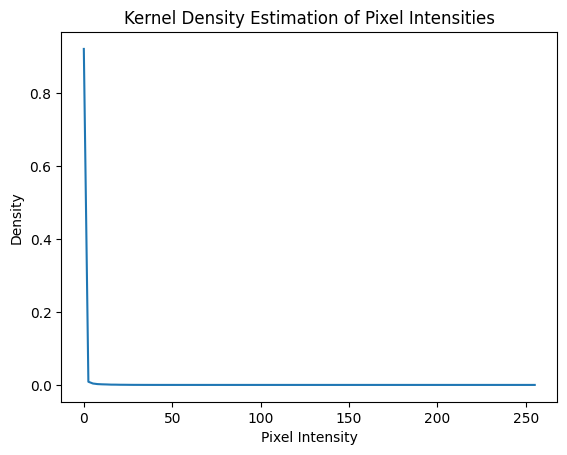

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

epithelial_img = tiff.imread("/Users/ferris/Desktop/Serial Section Overlay/000_Data/panCK_tiffs/epithelial/Ferris_TMA_2022_PDAC2_s0_a15_ac_full.tiff")

# Flatten the image to get a list of pixel intensities
pixel_values = epithelial_img.flatten()

# Create a Gaussian KDE object
kde = gaussian_kde(pixel_values)

# Define a range of values to evaluate the KDE
x_values = np.linspace(0, 255, 100)  # Assuming 8-bit grayscale image

# Evaluate the KDE
density = kde(x_values)

# Plot the KDE
plt.plot(x_values, density)
plt.title("Kernel Density Estimation of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.show()

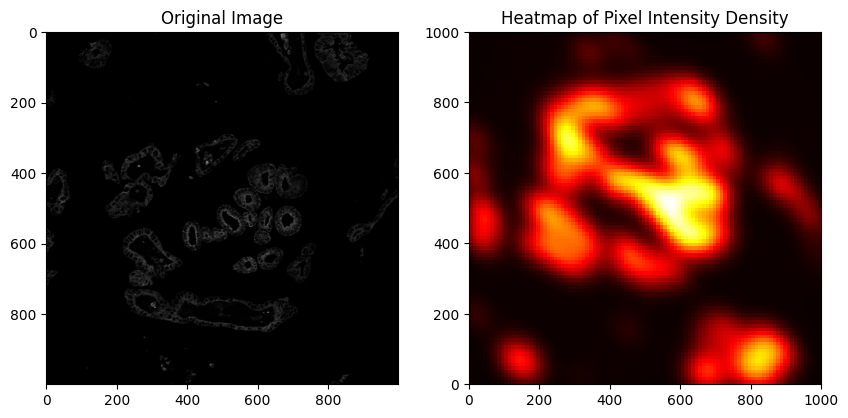

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from PIL import Image

# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/panCK_tiffs/epithelial/Ferris_TMA_2022_PDAC2_s0_a41_ac_full.tiff"
image = Image.open(image_path).convert("L")

# Convert the image to a numpy array
image_array = np.array(image)

# Get the pixel coordinates and their intensities
y_indices, x_indices = np.indices(image_array.shape)
pixel_intensities = image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, image_array.shape[1], 100)
y = np.linspace(0, image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

# Plot the original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the original grayscale image
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title("Original Image")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, image_array.shape[1], 0, image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

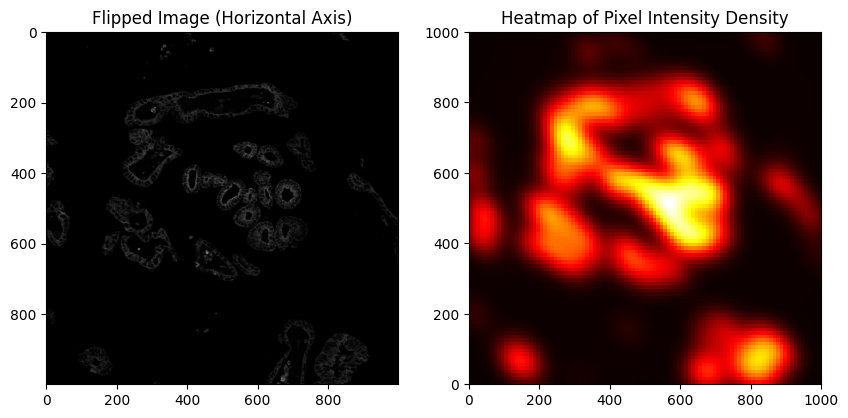

In [36]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/panCK_tiffs/epithelial/Ferris_TMA_2022_PDAC2_s0_a41_ac_full.tiff"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)



# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("Flipped Image (Horizontal Axis)")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

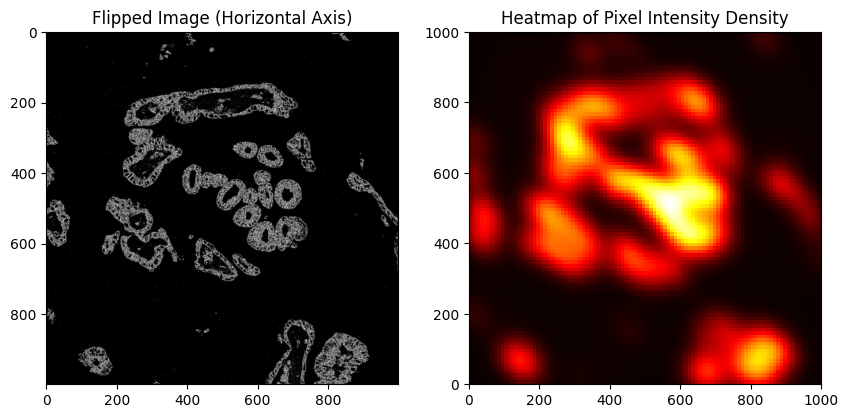

In [37]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Desktop/Serial Section Overlay/000_Data/panCK_tiffs/epithelial/Ferris_TMA_2022_PDAC2_s0_a41_ac_full.tiff"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("Flipped Image (Horizontal Axis)")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

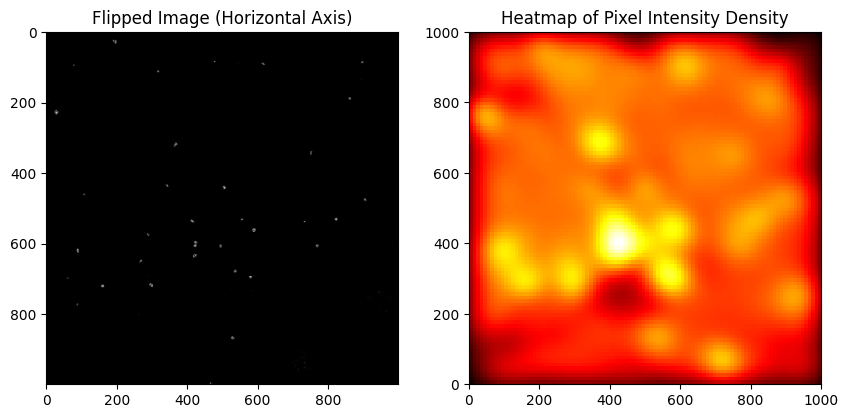

In [44]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NPOD6422_Body_ROI10/RAW_NPOD6422_Body_ROI10-1-0009.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("Flipped Image (Horizontal Axis)")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

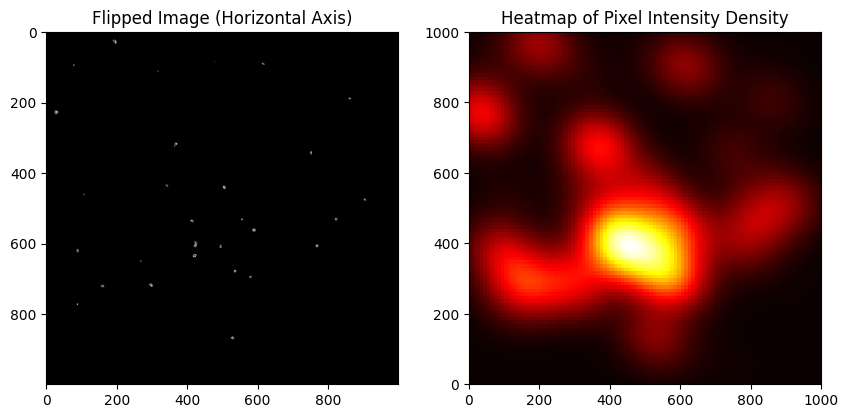

In [46]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NPOD6422_Body_ROI10/NPOD6422_Body_ROI10_Channel_9_Denoised.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("Flipped Image (Horizontal Axis)")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

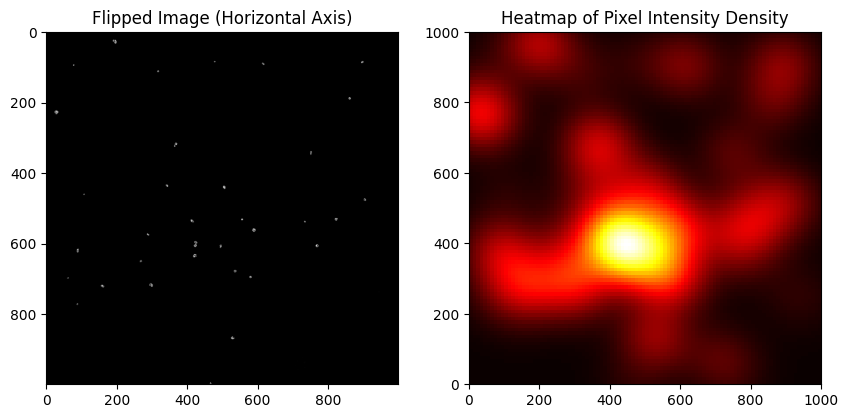

In [49]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NPOD6422_Body_ROI10/IMC_NPOD6422_Body_ROI10-1-0009.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("Flipped Image (Horizontal Axis)")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

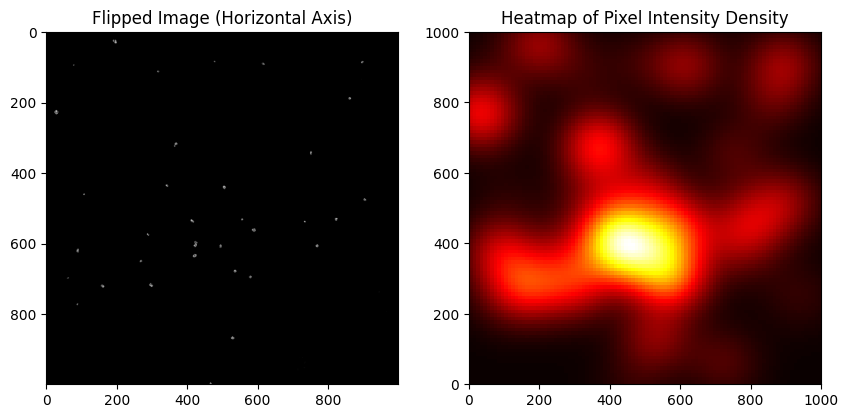

In [50]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NPOD6422_Body_ROI10/NPOD6422_Body_ROI10_9.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("Flipped Image (Horizontal Axis)")

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Heatmap of Pixel Intensity Density")

plt.show()

# HERE BE DRAGONS

In [13]:
#load libraries
import numpy as np
from skimage.transform import rescale
import pystackreg
from pystackreg import StackReg
import glob
import gc
import os
import sys
import tifffile as tiff
from sys import getsizeof
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
import imagecodecs
from matplotlib.colors import ListedColormap
from skimage import measure, io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from PIL import Image
import tifffile

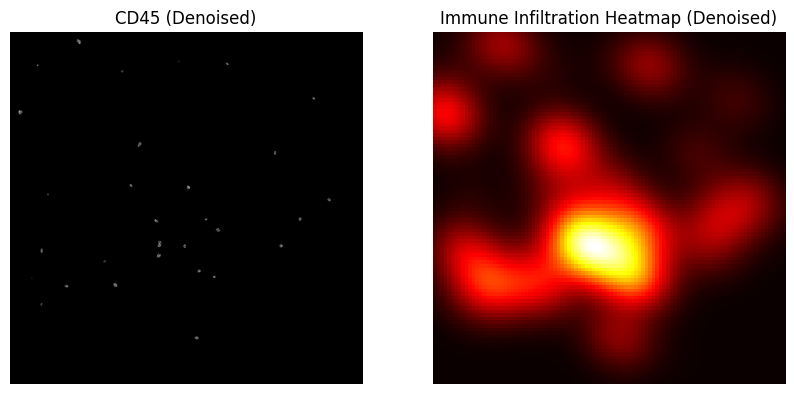

In [21]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NewOfficialData/3D module/NPOD6422_Body_ROI10/NPOD6422_Body_ROI10_Channel_4_CD8_Denoised.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=7)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("CD45 (Denoised)")
plt.axis('off') 

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Immune Infiltration Heatmap (Denoised)")
plt.axis('off') 

plt.savefig("CD45_Immune_Infiltration_Heatmap_3D_Denoised_g7.pdf", format='pdf', dpi=300)

plt.show()

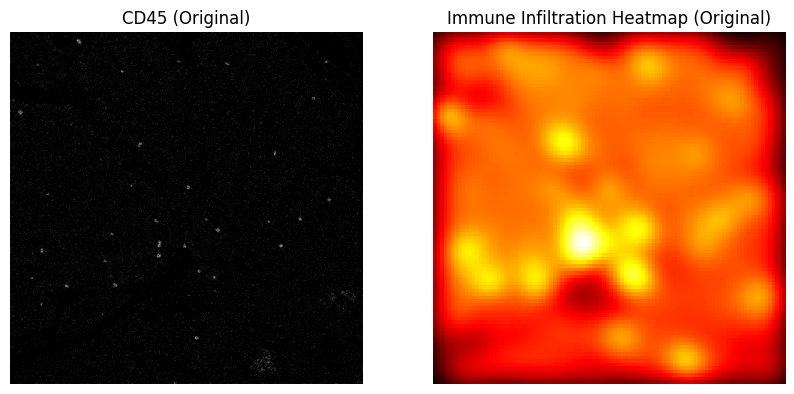

In [22]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NewOfficialData/RAW/NPOD6422_Body_ROI10/Raw_NPOD6422_Body_ROI10_Dy(162)_CD8.ome.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=7)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("CD45 (Original)")
plt.axis('off') 

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Immune Infiltration Heatmap (Original)")
plt.axis('off') 

plt.savefig("CD45_Immune_Infiltration_Heatmap_Original_g7.pdf", format='pdf', dpi=300)

plt.show()

In [ ]:
#OK! Try with CD4, because I remember checking and that looked particularly good

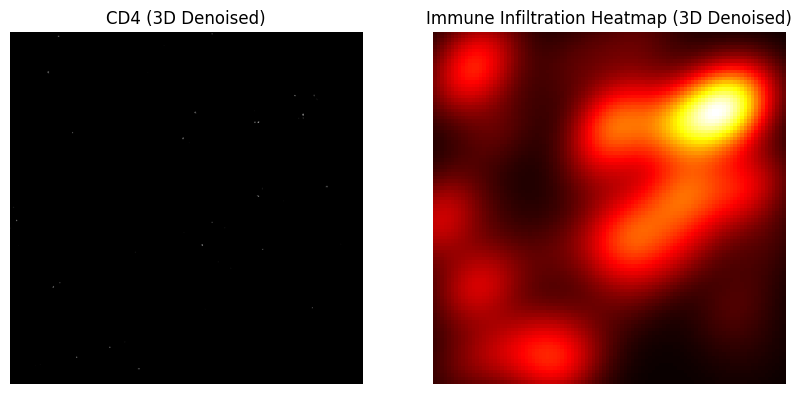

In [25]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NewOfficialData/3D module/NPOD6422_Body_ROI10/NPOD6422_Body_ROI10_Channel_14_CD4_Denoised.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=5)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("CD4 (3D Denoised)")
plt.axis('off') 

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Immune Infiltration Heatmap (3D Denoised)")
plt.axis('off') 

plt.savefig("CD4_Immune_Infiltration_Heatmap_3D_Denoised_g5.pdf", format='pdf', dpi=300)

plt.show()

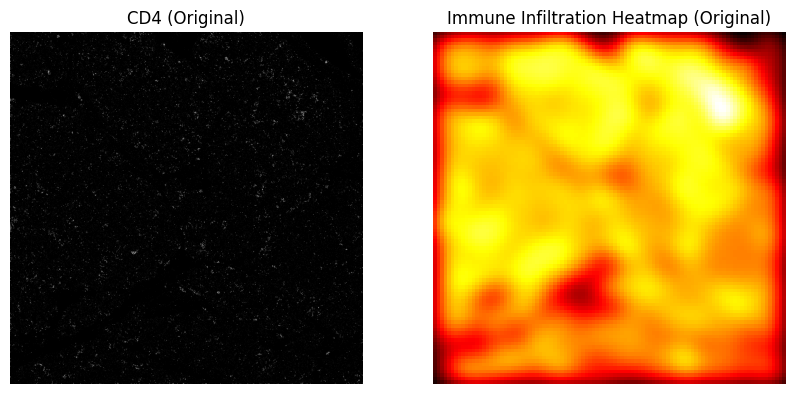

In [26]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NewOfficialData/RAW/NPOD6422_Body_ROI10/Raw_NPOD6422_Body_ROI10_Gd(156)_CD4.ome.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=5)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("CD4 (Original)")
plt.axis('off') 

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Immune Infiltration Heatmap (Original)")
plt.axis('off') 

plt.savefig("CD4_Immune_Infiltration_Heatmap_Original_g5.pdf", format='pdf', dpi=300)

plt.show()

In [15]:
image_path = '/Users/ferris/Downloads/ResultsChannelBan/RAW/NPOD6389_Tail_ROI4/NPOD6389_Tail_ROI4.tif'

image = tifffile.imread(image_path)

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=5)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("CD4 (Original)")
plt.axis('off') 

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Immune Infiltration Heatmap (Original)")
plt.axis('off') 

plt.savefig("CD4_Immune_Infiltration_Heatmap_Original_g5.pdf", format='pdf', dpi=300)

plt.show()

ValueError: axes don't match array

In [16]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def adjust_brightness(image, gamma=1.0):
    # Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Load the image using tifffile
image_path = '/Users/ferris/Downloads/ResultsChannelBan/RAW/NPOD6389_Tail_ROI4/NPOD6389_Tail_ROI4.tif'
image = tifffile.imread(image_path)

# Ensure the image has multiple channels
if image.ndim > 2:
    num_channels = image.shape[0]
else:
    raise ValueError("The image does not have multiple channels.")

# Loop through each channel
for channel_index in range(num_channels):
    # Extract the channel
    channel_image = image[channel_index]

    # Flip the image along the horizontal axis
    flipped_image = np.flipud(channel_image)

    # Convert the original and flipped images to numpy arrays
    original_image_array = np.array(channel_image)
    flipped_image_array = np.array(flipped_image)

    # Get the pixel coordinates and their intensities from the original image
    y_indices, x_indices = np.indices(original_image_array.shape)
    pixel_intensities = original_image_array.flatten()
    pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

    # Perform 2D kernel density estimation
    kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

    # Create a grid for the heatmap
    x = np.linspace(0, original_image_array.shape[1], 100)
    y = np.linspace(0, original_image_array.shape[0], 100)
    x_grid, y_grid = np.meshgrid(x, y)
    coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate the KDE to create the heatmap
    density = kde(coords).reshape(x_grid.shape)

    # Adjust brightness of the flipped image
    flipped_image_array = adjust_brightness(flipped_image_array, gamma=3)

    # Plot the flipped original image and the heatmap
    plt.figure(figsize=(10, 10))

    # Plot the flipped grayscale image
    plt.subplot(1, 2, 1)
    plt.imshow(flipped_image_array, cmap='gray')
    plt.title(f"Channel {channel_index + 1} (Original)")
    plt.axis('off')

    # Plot the heatmap with a gradient
    plt.subplot(1, 2, 2)
    plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
    plt.title(f"Immune Infiltration Heatmap (Channel {channel_index + 1})")
    plt.axis('off')

    # Save the plot as a PDF
    plt.savefig(f"Channel_{channel_index + 1}_Immune_Infiltration_Heatmap_Original_g5.pdf", format='pdf', dpi=300)

    # Close the plot to avoid memory issues
    plt.close()

In [9]:
image_path = '/Users/ferris/Downloads/ResultsChannelBan/RAW/NPOD6389_Tail_ROI4/NPOD6389_Tail_ROI4.tif'
image = Image.open(image_path)

# Check the number of channels
num_channels = len(image.getbands())
num_channels

1

In [14]:
image_path = '/Users/ferris/Downloads/ResultsChannelBan/RAW/NPOD6389_Tail_ROI4/NPOD6389_Tail_ROI4.tif'

image = tifffile.imread(image_path)

In [ ]:
# Load the TIFF image and convert to grayscale
image_path = "/Users/ferris/Downloads/NewOfficialData/3D module/NPOD6422_Body_ROI10/NPOD6422_Body_ROI10_Channel_14_CD4_Denoised.tif"
image = Image.open(image_path).convert("L")

# Flip the image along the horizontal axis
flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

# Convert the original and flipped images to numpy arrays
original_image_array = np.array(image)
flipped_image_array = np.array(flipped_image)

# Get the pixel coordinates and their intensities from the original image
y_indices, x_indices = np.indices(original_image_array.shape)
pixel_intensities = original_image_array.flatten()
pixel_coords = np.column_stack((x_indices.flatten(), y_indices.flatten()))

# Perform 2D kernel density estimation
kde = gaussian_kde(pixel_coords.T, weights=pixel_intensities, bw_method='scott')

# Create a grid for the heatmap
x = np.linspace(0, original_image_array.shape[1], 100)
y = np.linspace(0, original_image_array.shape[0], 100)
x_grid, y_grid = np.meshgrid(x, y)
coords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluate the KDE to create the heatmap
density = kde(coords).reshape(x_grid.shape)

def adjust_brightness(image, gamma=1.0):
     #Apply gamma correction to increase brightness
    return np.power(image, gamma)

# Assuming ref and mov are your images
flipped_image_array = adjust_brightness(flipped_image_array, gamma=5)

# Plot the flipped original image and the heatmap
plt.figure(figsize=(10, 10))

# Plot the flipped grayscale image
plt.subplot(1, 2, 1)
plt.imshow(flipped_image_array, cmap='gray')
plt.title("CD4 (3D Denoised)")
plt.axis('off') 

# Plot the heatmap with a gradient
plt.subplot(1, 2, 2)
plt.imshow(density, cmap='hot', origin='lower', extent=[0, original_image_array.shape[1], 0, original_image_array.shape[0]])
plt.title("Immune Infiltration Heatmap (3D Denoised)")
plt.axis('off') 

plt.savefig("CD4_Immune_Infiltration_Heatmap_3D_Denoised_g5.pdf", format='pdf', dpi=300)

plt.show()